In [48]:
from lab01 import environment, MABe_agent
from collections import defaultdict
import numpy as np

In [49]:
class Q_agent(MABe_agent):
    def __init__(self, envir, init_location, epsilon, alpha = 0.1, gamma = 0.99):
        super().__init__(envir, init_location, epsilon)
        self.alpha = alpha
        self.gamma = gamma

        self.Q_tabel = defaultdict(lambda: defaultdict(float))

    def _ensure_state_actions(self, state, action_space):
        if state is None:
            return
        for a in action_space:
            _ = self.Q_tabel[state][a]

    def getAction(self, observation):
        state, action_space, reward = observation

        if reward is not None:
            self.reward_trace.append(reward)

            if self.lastState is not None and self.lastAction is not None:
                self._ensure_state_actions(state, action_space)

                if state is None or len(action_space) == 0:
                    max_next_Q = 0.0
                else:
                    max_next_Q = max(self.Q_tabel[state][a] for a in action_space)

                s, a = self.lastState, self.lastAction
                td_target  = reward + self.gamma * max_next_Q
                td_error = td_target - self.Q_tabel[s][a]

                self.Q_tabel[s][a] += self.alpha * td_error

        if state is not None:
            self.location_now = state
        self._ensure_state_actions(state, action_space)

        toss = np.random.rand()
        
        if state is None or toss < self.epsilon:
            action = np.random.choice(action_space)
        else:
            qvals = [self.Q_tabel[state][a] for a in action_space]
            maxQ = np.max(qvals)
            best_actions = [a for a in action_space if self.Q_tabel[state][a] == maxQ]
            action = np.random.choice(best_actions)

        self.lastState = state
        self.lastAction = action

        assert action in action_space, "INVALID action taken"
        return action

In [50]:
Envir = environment(8, 8)
Envir.get_Map()
Envir.map_Designate(17, 56, -15)
Envir.map_Designate(18, 56, -15)
Envir.map_Designate(19, 56, -15)
Envir.map_Designate(21, 56, -15)
Envir.map_Designate(25, 56, -15)
Envir.map_Designate(33, 56, -15)
Envir.map_Designate(41, 56, -15)
Envir.map_Designate(42, 56, -15)
Envir.map_Designate(43, 56, -15)
Envir.map_Designate(46, 56, -15)
Envir.map_Designate(47, 56, -15)
Envir.map_Designate(47, 56, -15)
Envir.map_Designate(15, 56, +15)
Envir.map_Designate(1, 10, +5)
Envir.map_Designate(26, 56, +20)

[[ 0  1  2  3  4  5  6  7]
 [ 8  9 10 11 12 13 14 15]
 [16 17 18 19 20 21 22 23]
 [24 25 26 27 28 29 30 31]
 [32 33 34 35 36 37 38 39]
 [40 41 42 43 44 45 46 47]
 [48 49 50 51 52 53 54 55]
 [56 57 58 59 60 61 62 63]]


In [51]:
init_location = 0
epsilon = 1e-4
dummy_q_agent = Q_agent(envir = Envir, init_location = init_location, epsilon = epsilon)

num_iter = 1000

log_freq = 100
Data_plot1 = []

for i in range(num_iter):
  env_observation = (init_location, Envir.action_space, None)
    
  if i > 0:
    env_observation = Envir.get_Observation(location = dummy_q_agent.location_now, action = chosen_action)

  chosen_action = dummy_q_agent.getAction(observation = env_observation)
    
  if (i + 1) % log_freq == 0:
    aver = np.mean(dummy_q_agent.reward_trace)
    Data_plot1.append(aver)
    print('iter: ' + str(i + 1) + '\t Total reward: ' + str(dummy_q_agent.get_TotalReward()) + '\t Average: ' + str(aver))

iter: 100	 Total reward: -60	 Average: -0.6060606060606061
iter: 200	 Total reward: -120	 Average: -0.6030150753768844
iter: 300	 Total reward: -210	 Average: -0.7023411371237458
iter: 400	 Total reward: -270	 Average: -0.6766917293233082
iter: 500	 Total reward: -300	 Average: -0.6012024048096193
iter: 600	 Total reward: -360	 Average: -0.6010016694490818
iter: 700	 Total reward: -390	 Average: -0.5579399141630901
iter: 800	 Total reward: -420	 Average: -0.5256570713391739
iter: 900	 Total reward: -465	 Average: -0.5172413793103449
iter: 1000	 Total reward: -495	 Average: -0.4954954954954955


In [52]:
class SARSA_agent(MABe_agent):
    def __init__(self, envir, init_location, epsilon, alpha = 0.1, gamma = 0.99):
        super().__init__(envir, init_location, epsilon)

        self.alpha = alpha
        self.gamma = gamma

        self.Q_tabel = {}
        self.lastAction = None

    def _init_state(self, state, action_space):
        if state is None:
            return
        if state not in self.Q_tabel or len(self.Q_tabel[state]) != len(action_space):
            self.Q_tabel[state] = np.zeros(len(action_space))

    def _epsilon_greedy(self, state, action_space):
        self._init_state(state, action_space)

        toss = np.random.rand()
        if toss < self.epsilon:
            return np.random.choive(action_space)

        qvals = self.Q_tabel[state]
        best_idx = np.flatnonzero(qvals == qvals.max())
        idx = np.random.choice(best_idx)
        return action_space[idx]
        
    def _get_q(self, state, action, action_space):
        self._ensure_state(state, action_space)
        idx = action_space.index(action)
        return self.Q_table[state][idx]
        
    def _set_q(self, state, action, action_space, value):
        self._ensure_state(state, action_space)
        idx = action_space.index(action)
        self.Q_table[state][idx] = value

    def getAction(self, observation):
        """
        observation = (location_now, action_space, pre_reward)
        - Ở bước t: env trả về (s_{t}, A(s_t), r_{t-1})
        - Ta phải chọn a_t theo ε-greedy tại s_t, rồi dùng SARSA để cập nhật Q(s_{t-1}, a_{t-1})
        """
        state, action_space, pre_reward = observation

        if location_now is not None:
          self.location_now = location_now

        # Chọn a' ở s' (on-policy) trước để dùng trong target
        # (nếu terminal mà action_space trống thì không chọn, nhưng thường action_space != [])
        self._ensure_state(state, action_space)
        action = self._epsilon_greedy(state, action_space)

        # Nếu đã có (s_{t-1}, a_{t-1}) và r_{t-1} thì cập nhật SARSA
        if (pre_reward is not None) and (self.lastState is not None) and (self.lastAction is not None):
          self.reward_trace.append(pre_reward)

          # Q(s_{t-1}, a_{t-1})
          q_old = self._get_q(self.lastState, self.lastAction, self.lastActionSpace)

          # target = r_{t-1} + gamma * Q(s_t, a_t) (với a_t = action)
          next_q = self._get_q(state, action, action_space)
          td_target = pre_reward + self.gamma * next_q

          # cập nhật
          q_new = q_old + self.alpha * (td_target - q_old)
          self._set_q(self.lastState, self.lastAction, self.lastActionSpace, q_new)

        # cập nhật vết cho bước sau
        self.lastState = state
        self.lastAction = action
        self.lastActionSpace = list(action_space)  # copy để cố định mapping chỉ số

        # trả về a_t để env thực thi
        assert action in action_space, "INVALID action taken"
        return action

In [53]:
init_location = 0
epsilon = 1e-2
dummy_sarsa_agent = Q_agent(envir = Envir, init_location = init_location, epsilon = epsilon)

num_iter = 1000

log_freq = 100
Data_plot2 = []

for i in range(num_iter):
  env_observation = (init_location, Envir.action_space, None)
    
  if i > 0:
    env_observation = Envir.get_Observation(location = dummy_sarsa_agent.location_now, action = chosen_action)

  chosen_action = dummy_sarsa_agent.getAction(observation = env_observation)
    
  if (i + 1) % log_freq == 0:
    aver = np.mean(dummy_sarsa_agent.reward_trace)
    Data_plot2.append(aver)
    print('iter: ' + str(i + 1) + '\t Total reward: ' + str(dummy_sarsa_agent.get_TotalReward()) + '\t Average: ' + str(aver))

iter: 100	 Total reward: -100	 Average: -1.0101010101010102
iter: 200	 Total reward: -205	 Average: -1.0301507537688441
iter: 300	 Total reward: -235	 Average: -0.7859531772575251
iter: 400	 Total reward: -245	 Average: -0.6140350877192983
iter: 500	 Total reward: -80	 Average: -0.16032064128256512
iter: 600	 Total reward: 90	 Average: 0.15025041736227046
iter: 700	 Total reward: 255	 Average: 0.3648068669527897
iter: 800	 Total reward: 420	 Average: 0.5256570713391739
iter: 900	 Total reward: 590	 Average: 0.6562847608453838
iter: 1000	 Total reward: 755	 Average: 0.7557557557557557


In [54]:
import matplotlib.pyplot as plt

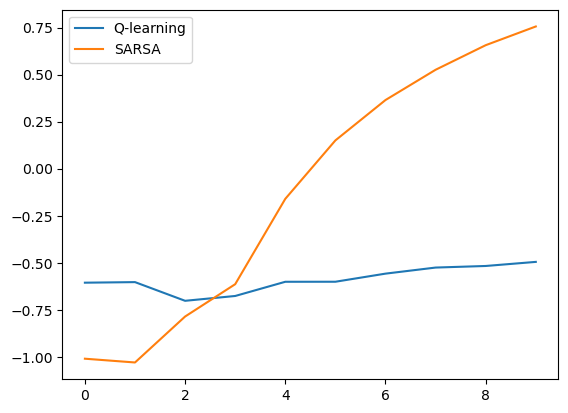

In [55]:
fig = plt.figure()
plt.plot(Data_plot1, label = "Q-learning")
plt.plot(Data_plot2, label = "SARSA")
plt.legend()
plt.show()